In [1]:
!pip install matplotlib numpy Pillow tqdm opencv-python torch torchvision albumentations

In [2]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from glob import glob
from tqdm import tqdm

# Set device
device = torch.device('mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: mps


In [3]:
## Data Loading and Augmentation

In [4]:
class BarnacleDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.img_files = sorted(glob(os.path.join(data_dir, 'imgs', '*.png')))
    def __len__(self):
        return len(self.img_files)
    def __getitem__(self, idx):
        img_path = self.img_files[idx]
        mask_path = img_path.replace('imgs', 'masks')
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        _, mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
        mask = mask / 255.0
        img = torch.from_numpy(img.transpose(2, 0, 1)).float() / 255.0
        mask = torch.from_numpy(mask).unsqueeze(0).float()
        if self.transform:
            img = self.transform(img)
            mask = self.transform(mask)
        return img, mask

In [5]:
## U-Net Model Definition

In [6]:
import torch.nn.functional as F

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )
    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)
    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super().__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)
    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [7]:
## U-Net Model Definition

In [8]:
import torch.nn.functional as F

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )
    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)
    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super().__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)
    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [9]:
## Data Preparation and Visualization

In [10]:
# Data augmentation
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
])

# Create datasets and dataloaders
train_dataset = BarnacleDataset('../data/tiles/train', transform=train_transform)
val_dataset = BarnacleDataset('../data/tiles/val')
print("Current working directory:", os.getcwd())
print("Dataset train image files:", train_dataset.img_files[:3])
print("Total in dataset:", len(train_dataset))
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=0)

print(f'Training samples: {len(train_dataset)}')
print(f'Validation samples: {len(val_dataset)}')

Current working directory: /Users/eddiebae/CS/BarnacleUNetIdentification/Pytorch-UNet/notebooks
Dataset train image files: ['../data/tiles/train/imgs/img1_tile_0000.png', '../data/tiles/train/imgs/img1_tile_0001.png', '../data/tiles/train/imgs/img1_tile_0002.png']
Total in dataset: 192
Training samples: 192
Validation samples: 192


In [11]:
# Data augmentation
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
])

# Create datasets and dataloaders
train_dataset = BarnacleDataset('../data/tiles/train', transform=train_transform)
val_dataset = BarnacleDataset('../data/tiles/val')
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=0)

print(f'Training samples: {len(train_dataset)}')
print(f'Validation samples: {len(val_dataset)}')

Training samples: 192
Validation samples: 192


In [12]:
## Training and Validation Functions

In [13]:
def dice_score(pred, target):
    pred = torch.sigmoid(pred) > 0.5
    target = target > 0.5
    intersection = (pred & target).sum()
    union = pred.sum() + target.sum()
    return (2 * intersection) / (union + 1e-6)

def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    total_dice = 0
    for imgs, masks in tqdm(loader, desc='Training'):
        imgs = imgs.to(device)
        masks = masks.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        total_dice += dice_score(outputs, masks).item()
    return total_loss / len(loader), total_dice / len(loader)

def validate_epoch(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    total_dice = 0
    with torch.no_grad():
        for imgs, masks in tqdm(loader, desc='Validation'):
            imgs = imgs.to(device)
            masks = masks.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, masks)
            total_loss += loss.item()
            total_dice += dice_score(outputs, masks).item()
    return total_loss / len(loader), total_dice / len(loader)

In [14]:
## Model Training

In [15]:
import os
os.makedirs('../models', exist_ok=True)
model = UNet(n_channels=3, n_classes=1).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
num_epochs = 20
train_losses, val_losses, train_dices, val_dices = [], [], [], []
best_val_dice = 0
for epoch in range(num_epochs):
    print(f'\nEpoch {epoch+1}/{num_epochs}')
    train_loss, train_dice = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_dice = validate_epoch(model, val_loader, criterion, device)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_dices.append(train_dice)
    val_dices.append(val_dice)
    print(f'Train Loss: {train_loss:.4f}, Train Dice: {train_dice:.4f}')
    print(f'Val Loss: {val_loss:.4f}, Val Dice: {val_dice:.4f}')
    if val_dice > best_val_dice:
        best_val_dice = val_dice
        torch.save(model.state_dict(), '../models/best_barnacle_unet.pth')
        print(f'New best model saved! Dice: {val_dice:.4f}')
    if epoch > 5 and val_dice < 0.1:
        print('Early stopping due to poor performance')
        break


Epoch 1/20


Validation: 100%|█████████████████████| 24/24 [00:20<00:00,  1.19it/s]


Train Loss: 0.6865, Train Dice: 0.6340
Val Loss: 0.6757, Val Dice: 0.5888
New best model saved! Dice: 0.5888

Epoch 2/20


Validation: 100%|█████████████████████| 24/24 [00:21<00:00,  1.12it/s]


Train Loss: 0.6750, Train Dice: 0.6614
Val Loss: 0.6791, Val Dice: 0.5526

Epoch 3/20


Validation: 100%|█████████████████████| 24/24 [00:20<00:00,  1.17it/s]


Train Loss: 0.6684, Train Dice: 0.6702
Val Loss: 0.6684, Val Dice: 0.5529

Epoch 4/20


Validation: 100%|█████████████████████| 24/24 [00:20<00:00,  1.16it/s]


Train Loss: 0.6695, Train Dice: 0.6557
Val Loss: 0.6791, Val Dice: 0.5444

Epoch 5/20


Validation: 100%|█████████████████████| 24/24 [00:18<00:00,  1.31it/s]


Train Loss: 0.6650, Train Dice: 0.6795
Val Loss: 0.6881, Val Dice: 0.5370

Epoch 6/20


Validation: 100%|█████████████████████| 24/24 [00:18<00:00,  1.33it/s]


Train Loss: 0.6625, Train Dice: 0.6176
Val Loss: 0.6727, Val Dice: 0.5422

Epoch 7/20


Validation: 100%|█████████████████████| 24/24 [00:19<00:00,  1.26it/s]


Train Loss: 0.6633, Train Dice: 0.6879
Val Loss: 0.6743, Val Dice: 0.5676

Epoch 8/20


Validation: 100%|█████████████████████| 24/24 [00:20<00:00,  1.15it/s]


Train Loss: 0.6541, Train Dice: 0.6463
Val Loss: 0.6670, Val Dice: 0.5686

Epoch 9/20


Validation: 100%|█████████████████████| 24/24 [00:20<00:00,  1.14it/s]


Train Loss: 0.6523, Train Dice: 0.6851
Val Loss: 0.6637, Val Dice: 0.5616

Epoch 10/20


Validation: 100%|█████████████████████| 24/24 [00:21<00:00,  1.10it/s]


Train Loss: 0.6430, Train Dice: 0.6657
Val Loss: 0.6164, Val Dice: 0.4922

Epoch 11/20


Validation: 100%|█████████████████████| 24/24 [00:21<00:00,  1.13it/s]


Train Loss: 0.6584, Train Dice: 0.6725
Val Loss: 0.6410, Val Dice: 0.5095

Epoch 12/20


Validation: 100%|█████████████████████| 24/24 [00:21<00:00,  1.12it/s]


Train Loss: 0.6471, Train Dice: 0.6962
Val Loss: 0.6984, Val Dice: 0.5713

Epoch 13/20


Validation: 100%|█████████████████████| 24/24 [00:21<00:00,  1.13it/s]


Train Loss: 0.6500, Train Dice: 0.6734
Val Loss: 0.6640, Val Dice: 0.5375

Epoch 14/20


Validation: 100%|█████████████████████| 24/24 [00:21<00:00,  1.13it/s]


Train Loss: 0.6412, Train Dice: 0.6824
Val Loss: 0.7155, Val Dice: 0.5736

Epoch 15/20


Validation: 100%|█████████████████████| 24/24 [00:25<00:00,  1.05s/it]


Train Loss: 0.6418, Train Dice: 0.6704
Val Loss: 0.6661, Val Dice: 0.5456

Epoch 16/20


Validation: 100%|█████████████████████| 24/24 [00:19<00:00,  1.20it/s]


Train Loss: 0.6407, Train Dice: 0.6621
Val Loss: 0.6480, Val Dice: 0.5256

Epoch 17/20


Validation: 100%|█████████████████████| 24/24 [00:18<00:00,  1.33it/s]


Train Loss: 0.6336, Train Dice: 0.6791
Val Loss: 0.6643, Val Dice: 0.5159

Epoch 18/20


Validation: 100%|█████████████████████| 24/24 [00:21<00:00,  1.14it/s]


Train Loss: 0.6399, Train Dice: 0.6717
Val Loss: 0.6731, Val Dice: 0.5487

Epoch 19/20


Validation: 100%|█████████████████████| 24/24 [00:22<00:00,  1.09it/s]


Train Loss: 0.6419, Train Dice: 0.6929
Val Loss: 0.7155, Val Dice: 0.5744

Epoch 20/20


Validation: 100%|█████████████████████| 24/24 [00:20<00:00,  1.18it/s]

Train Loss: 0.6436, Train Dice: 0.6649
Val Loss: 0.6165, Val Dice: 0.3518


In [16]:
## Training Curves

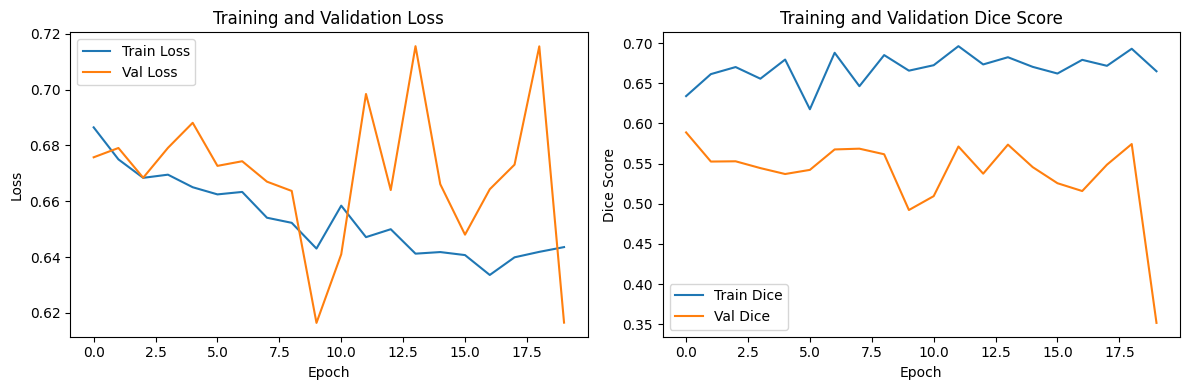

In [17]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_dices, label='Train Dice')
plt.plot(val_dices, label='Val Dice')
plt.title('Training and Validation Dice Score')
plt.xlabel('Epoch')
plt.ylabel('Dice Score')
plt.legend()
plt.tight_layout()
plt.savefig('training_curves.png', dpi=300, bbox_inches='tight')
plt.show()

In [18]:
## Sample Predictions on Validation Data

/var/folders/p2/cdj69_b90yd1md9r563bvt8w0000gn/T/ipykernel_4451/3639788854.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('../models/be

Final Dice Score: 0.0215


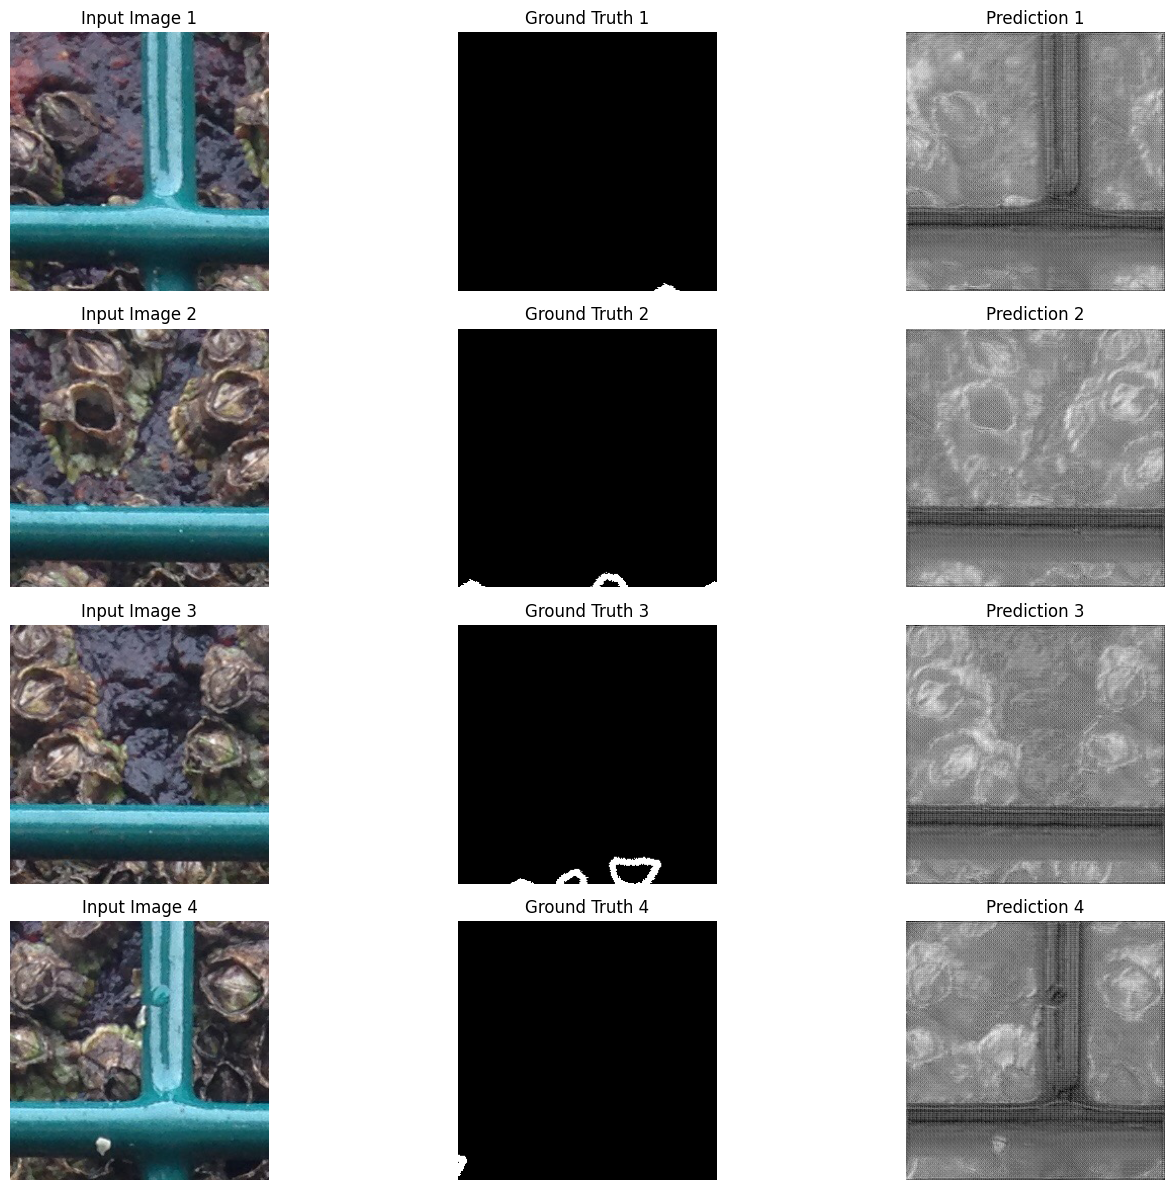

In [19]:
model.load_state_dict(torch.load('../models/best_barnacle_unet.pth'))
model.eval()
test_batch = next(iter(val_loader))
test_imgs, test_masks = test_batch
with torch.no_grad():
    test_imgs = test_imgs.to(device)
    predictions = model(test_imgs)
    predictions = torch.sigmoid(predictions)
final_dice = dice_score(predictions, test_masks.to(device)).item()
print(f'Final Dice Score: {final_dice:.4f}')
plt.figure(figsize=(15, 12))
for i in range(4):
    plt.subplot(4, 3, i*3+1)
    plt.imshow(test_imgs[i].cpu().permute(1, 2, 0))
    plt.title(f'Input Image {i+1}')
    plt.axis('off')
    plt.subplot(4, 3, i*3+2)
    plt.imshow(test_masks[i].squeeze().cpu(), cmap='gray')
    plt.title(f'Ground Truth {i+1}')
    plt.axis('off')
    plt.subplot(4, 3, i*3+3)
    plt.imshow(predictions[i].squeeze().cpu(), cmap='gray')
    plt.title(f'Prediction {i+1}')
    plt.axis('off')
plt.tight_layout()
plt.savefig('sample_predictions.png', dpi=300, bbox_inches='tight')
plt.show()

In [20]:
## Inference on New Images

In [21]:
def predict_full_image(model, img_path, device, out_threshold=0.5):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_tensor = torch.from_numpy(img.transpose(2, 0, 1)).float() / 255.0
    img_tensor = img_tensor.unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(img_tensor)
        output = torch.sigmoid(output)
        mask = (output > out_threshold).float()
    return mask.squeeze().cpu().numpy()
# Example usage:
# pred_mask = predict_full_image(model, 'path/to/new_image.png', device)
# plt.imshow(pred_mask, cmap='gray')
# plt.show()